# Libraries


In [ ]:
# install pytorch grad cam library
#!pip install grad-cam

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import shutil
import time
from tqdm import tqdm
from PIL import Image
import copy
import cv2
from sklearn import preprocessing
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from matplotlib import image
from matplotlib import pyplot
cudnn.benchmark = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define path and import custom funcions

In [5]:
from utils.generic_functions import *
from GradCAM.GradCAM import *
from GradCAM.GradCAMVit import *

# Load models


In [6]:
# code to load models
dir_resnet = 'results_imagenette/resnet'
dir_vit =  'results_imagenette/vit'
dir_inception = 'results_imagenette/inception'
dir_vgg =  'results_imagenette/vgg'
dir_mobilenet = 'results_imagenette/mobilenet'

resnet = load_model('resnet', path = 'results_imagenette', ft=True)
vit = load_model('vit',  path = 'results_imagenette', ft=True)
inception = load_model('inception',  path = 'results_imagenette', ft=True)
mobilenet = load_model('mobilenet',  path = 'results_imagenette', ft=True)
vgg = load_model('vgg',  path = 'results_imagenette', ft=True)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/sofiamongardi/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:08<00:00, 11.6MB/s]
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /Users/sofiamongardi/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:31<00:00, 11.1MB/s] 
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /Users/sofiamongardi/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 12.3MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/sofiamongardi/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:46<00:00, 11.9MB/s] 


# Load test images

In [7]:
ids_to_names = load_txt('utils/id_to_name.txt')
ids_to_names

{'tench': 'n01440764',
 'dog': 'n02102040',
 'cassetteplayer': 'n02979186',
 'chainsaw': 'n03000684',
 'church': 'n03028079',
 'frenchhorn': 'n03394916',
 'garbagetruck': 'n03417042',
 'gaspump': 'n03425413',
 'golfball': 'n03445777',
 'parachute': 'n03888257'}

In [10]:
# load images
dir_images = 'Images'
dict_images = {}
original_labels = []
# print(os.listdir(dir_images))
for cl in os.listdir(dir_images):
  # print(cl)
  images = os.listdir(os.path.join(dir_images, cl))
  # print(len(images))

  for img in images:
    dict_images[img] = ids_to_names[cl]
    original_labels.append(cl)
# Add label
img_labels = pd.DataFrame.from_dict(dict_images, orient='index')
img_labels.reset_index(inplace=True)

le = preprocessing.LabelEncoder()
le.fit(img_labels.iloc[:,1])
# print(le.classes_)
img_labels['labels_enc'] = le.transform(img_labels.iloc[:,1])
img_labels[0] = original_labels
img_labels

,index,0,labels_enc
0,chainsaw_21.jpg,chainsaw,3
1,chainsaw_20.jpg,chainsaw,3
2,chainsaw_22.jpg,chainsaw,3
3,chainsaw_23.jpg,chainsaw,3
4,chainsaw_27.jpg,chainsaw,3
...,...,...,...
302,frenchhorn_27.jpg,frenchhorn,5
303,frenchhorn_23.jpg,frenchhorn,5
304,frenchhorn_22.jpg,frenchhorn,5
305,frenchhorn_20.jpg,frenchhorn,5


In [11]:
img_labels[0]+'/'+img_labels['index']

0          chainsaw/chainsaw_21.jpg
1          chainsaw/chainsaw_20.jpg
2          chainsaw/chainsaw_22.jpg
3          chainsaw/chainsaw_23.jpg
4          chainsaw/chainsaw_27.jpg
                   ...             
302    frenchhorn/frenchhorn_27.jpg
303    frenchhorn/frenchhorn_23.jpg
304    frenchhorn/frenchhorn_22.jpg
305    frenchhorn/frenchhorn_20.jpg
306    frenchhorn/frenchhorn_21.jpg
Length: 307, dtype: object

# Run GradCAM to get activation maps of predicted images

In [14]:
# Create directories
# Run only the first time!
models = ['resnet', 'vit', 'inception', 'mobilenet', 'vgg']
os.mkdir('grad_images_imagenette_gs')
for m in models:
  dire = os.path.join('grad_images_imagenette_gs', m)
  os.mkdir(dire)
  for cl in ids_to_names:
    os.mkdir(os.path.join(dire, cl))

In [ ]:
# get activation maps
models = ['resnet', 'vit', 'inception', 'mobilenet', 'vgg']
# models = ['vit']
for m in models:
  print('-----------', m, '------------')
  model = get_model(m, resnet, vit, inception, mobilenet, vgg)
  transform = get_transform(m)
  target_layer = get_target_layer(m,resnet, vit, inception, mobilenet, vgg)
  print(target_layer)

  is_vit = True if m == 'vit' else False
  is_resnet = False
  # is_resnet = True if m == 'resnet' else False
  # print(is_resnet)
  if is_vit == False:
    model_CAM = Model_gradCAM2(model, target_layer, is_resnet = is_resnet, is_vit= is_vit)
    # get data
    dataset = CustomImageDataset(img_labels, dir_images, transform,explain=True)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    dire = os.path.join('grad_images_imagenette_gs', m)

    for img, label in dataloader:

      img_name = label[1]
      img_name  = img_name[0]
      label = label[0]
      cam = model_CAM(img, label)
      # print(cam.shape)
      # plt.imshow(cam.squeeze().numpy(), alpha=0.5, cmap='jet')
      if cam is not None:
        get_full_cam2(img_name, cam, dire)
      if cam is None:
        print(img_name)
  else:
      dire = os.path.join('grad_images_imagenette_gs', m)
      img_path = img_labels[0]+'/'+img_labels['index']
      for img in img_path:
        # print(img)
        output = dire + '/'+ '/'.join(img.split('/')[-2:])
        # print(output)
        GradCAMViT(model, img, output)
  print('Model Done!')


# Check misclassified samples

In [ ]:
models = ['resnet', 'vit', 'inception', 'mobilenet', 'vgg']
missclass = []
for m in models:
  print('-------', m, '-------')
  dire_grad = os.path.join('grad_images_imagenette_gs', m)
  for cl in ids_to_names:
    grad_files = os.listdir(os.path.join(dire_grad, cl))
    img_files = os.listdir(os.path.join('Images', cl))
    if len(grad_files) != len(img_files):
      print('Number of miclassified samples for ', cl, ': ', len(img_files)- len(grad_files))
      print('Misclassified samples: ', [x for x in img_files if x not in grad_files])
      missclass.append([x for x in img_files if x not in grad_files])

missclass = flatten_comprehension([item for item in missclass])

------- resnet -------
Number of miclassified samples for  cassetteplayer :  3
Misclassified samples:  ['cassetteplayer_12.jpg', 'cassetteplayer_28.jpg', 'cassetteplayer_29.jpg']
Number of miclassified samples for  golfball :  1
Misclassified samples:  ['golfball_23.jpg']
------- vit -------
------- inception -------
Number of miclassified samples for  cassetteplayer :  1
Misclassified samples:  ['cassetteplayer_28.jpg']
Number of miclassified samples for  chainsaw :  1
Misclassified samples:  ['chainsaw_27.jpg']
------- mobilenet -------
Number of miclassified samples for  cassetteplayer :  1
Misclassified samples:  ['cassetteplayer_18.jpg']
Number of miclassified samples for  chainsaw :  1
Misclassified samples:  ['chainsaw_27.jpg']
------- vgg -------
Number of miclassified samples for  cassetteplayer :  3
Misclassified samples:  ['cassetteplayer_12.jpg', 'cassetteplayer_28.jpg', 'cassetteplayer_29.jpg']
Number of miclassified samples for  chainsaw :  2
Misclassified samples:  ['cha

# Load manually segmented and GradCAM images

In [ ]:
# load manual segmented images
dir_images = 'ManualSegmentation'
dict_images = {}
images = list()
for cl in os.listdir(dir_images):
  images.append(os.path.join(dir_images, cl))

# load gradCam greyscale images for all
dir_images = 'grad_images_imagenette_gs'
dict_images = {}
vit_images = list()
inception_images = list()
resnet_images = list()
mobile_images = list()
vgg_images = list()
for cl in os.listdir(dir_images):
  if 'inception' in cl:
    for dir in os.listdir(os.path.join(dir_images,cl)):
      for im in os.listdir(os.path.join(os.path.join(dir_images,cl),dir)):
        inception_images.append(os.path.join(os.path.join(os.path.join(dir_images,cl),dir),im))
  if 'vit' in cl:
    for dir in os.listdir(os.path.join(dir_images,cl)):
      for im in os.listdir(os.path.join(os.path.join(dir_images,cl),dir)):
        vit_images.append(os.path.join(os.path.join(os.path.join(dir_images,cl),dir),im))
  if 'resnet' in cl:
    for dir in os.listdir(os.path.join(dir_images,cl)):
      for im in os.listdir(os.path.join(os.path.join(dir_images,cl),dir)):
        resnet_images.append(os.path.join(os.path.join(os.path.join(dir_images,cl),dir),im))
  if 'mobile' in cl:
    for dir in os.listdir(os.path.join(dir_images,cl)):
      for im in os.listdir(os.path.join(os.path.join(dir_images,cl),dir)):
        mobile_images.append(os.path.join(os.path.join(os.path.join(dir_images,cl),dir),im))
  if 'vgg' in cl:
    for dir in os.listdir(os.path.join(dir_images,cl)):
      for im in os.listdir(os.path.join(os.path.join(dir_images,cl),dir)):
        vgg_images.append(os.path.join(os.path.join(os.path.join(dir_images,cl),dir),im))

In [ ]:
missclass.append('golfball_25.jpg')

In [ ]:
# Keep only common images
resnet_images = [item for item in resnet_images if item.split('/')[-1] not in missclass]
inception_images = [item for item in inception_images if item.split('/')[-1] not in missclass]
vit_images = [item for item in vit_images if item.split('/')[-1] not in missclass]
mobile_images = [item for item in mobile_images if item.split('/')[-1] not in missclass]
vgg_images = [item for item in vgg_images if item.split('/')[-1] not in missclass]

# Example of thresholding

In [ ]:
path_parachute = 'grad_images_imagenette_gs/resnet/parachute/parachute_7.jpeg'

B = image.imread(path_parachute)/255.
B_t = np.zeros_like(B)
B_t[B >= 0.8] = 1.0

# Get Metrics

In [ ]:
thresholds = np.arange(0,1.05,step=0.05)

IoU_resnet_all,IoU_inception_all,IoU_vit_all,IoU_mobile_all,IoU_vgg_all = {},{},{},{},{}
Prec_resnet_all,Prec_inception_all,Prec_vit_all,Prec_mobile_all,Prec_vgg_all={},{},{},{},{}
F2_resnet_all,F2_inception_all,F2_vit_all,F2_mobile_all,F2_vgg_all = {},{},{},{},{}
F1_resnet_all,F1_inception_all,F1_vit_all,F1_mobile_all,F1_vgg_all = {},{},{},{},{}
F0_resnet_all,F0_inception_all,F0_vit_all,F0_mobile_all,F0_vgg_all = {},{},{},{},{}
T1_resnet_all,T1_inception_all,T1_vit_all,T1_mobile_all,T1_vgg_all = {},{},{},{},{}
T2_resnet_all,T2_inception_all,T2_vit_all,T2_mobile_all,T2_vgg_all = {},{},{},{},{}
T3_resnet_all,T3_inception_all,T3_vit_all,T3_mobile_all,T3_vgg_all = {},{},{},{},{}

for t in thresholds:
  print(t)
  IoU_vit, IoU_inception, IoU_resnet, IoU_mobile, IoU_vgg = list(),list(),list(),list(),list()
  Prec_vit, Prec_inception, Prec_resnet, Prec_mobile, Prec_vgg = list(),list(),list(),list(),list()
  F2_resnet,F2_inception,F2_vit,F2_mobile,F2_vgg = list(),list(),list(),list(),list()
  F1_resnet,F1_inception,F1_vit,F1_mobile,F1_vgg = list(),list(),list(),list(),list()
  F0_resnet,F0_inception,F0_vit,F0_mobile,F0_vgg = list(),list(),list(),list(),list()
  T1_resnet,T1_inception,T1_vit,T1_mobile,T1_vgg = list(),list(),list(),list(),list()
  T2_resnet,T2_inception,T2_vit,T2_mobile,T2_vgg = list(),list(),list(),list(),list()
  T3_resnet,T3_inception,T3_vit,T3_mobile,T3_vgg = list(),list(),list(),list(),list()

  for i in range(len(vit_images)):
    for j in range(len(images)):
      if images[j].split('/')[-1].split('.')[0] == vit_images[i].split('/')[-1].split('.')[0]:
        compute_metrics(images[j],vit_images[i], t, IoU_vit, Prec_vit, F2_vit,F1_vit,F0_vit,T1_vit,T2_vit,T3_vit)

      if images[j].split('/')[-1].split('.')[0] == inception_images[i].split('/')[-1].split('.')[0]:
        compute_metrics(images[j],inception_images[i], t, IoU_inception, Prec_inception,F2_inception,F1_inception,F0_inception,T1_inception,T2_inception,T3_inception)

      if images[j].split('/')[-1].split('.')[0] == resnet_images[i].split('/')[-1].split('.')[0]:
        compute_metrics(images[j],resnet_images[i], t, IoU_resnet, Prec_resnet,F2_resnet,F1_resnet,F0_resnet,T1_resnet,T2_resnet,T3_resnet)

      if images[j].split('/')[-1].split('.')[0] == mobile_images[i].split('/')[-1].split('.')[0]:
        compute_metrics(images[j],mobile_images[i], t, IoU_mobile, Prec_mobile,F2_mobile,F1_mobile,F0_mobile,T1_mobile,T2_mobile,T3_mobile)

      if images[j].split('/')[-1].split('.')[0] == vgg_images[i].split('/')[-1].split('.')[0]:
        compute_metrics(images[j],vgg_images[i], t, IoU_vgg, Prec_vgg,F2_vgg,F1_vgg,F0_vgg,T1_vgg,T2_vgg,T3_vgg)

  IoU_inception_all[t],IoU_vit_all[t],IoU_resnet_all[t],IoU_mobile_all[t],IoU_vgg_all[t] = IoU_inception,IoU_vit,IoU_resnet,IoU_mobile,IoU_vgg
  Prec_inception_all[t],Prec_vit_all[t],Prec_resnet_all[t], Prec_mobile_all[t], Prec_vgg_all[t] = Prec_inception,Prec_vit,Prec_resnet,Prec_mobile,Prec_vgg
  F2_resnet_all[t],F2_inception_all[t],F2_vit_all[t],F2_mobile_all[t],F2_vgg_all[t] = F2_resnet,F2_inception,F2_vit,F2_mobile,F2_vgg
  F1_resnet_all[t],F1_inception_all[t],F1_vit_all[t],F1_mobile_all[t],F1_vgg_all[t] = F1_resnet,F1_inception,F1_vit,F1_mobile,F1_vgg
  F0_resnet_all[t],F0_inception_all[t],F0_vit_all[t],F0_mobile_all[t],F0_vgg_all[t] = F0_resnet,F0_inception,F0_vit,F0_mobile,F0_vgg
  T1_resnet_all[t],T1_inception_all[t],T1_vit_all[t],T1_mobile_all[t],T1_vgg_all[t] =  T1_resnet,T1_inception,T1_vit,T1_mobile,T1_vgg
  T2_resnet_all[t],T2_inception_all[t],T2_vit_all[t],T2_mobile_all[t],T2_vgg_all[t] =  T2_resnet,T2_inception,T2_vit,T2_mobile,T2_vgg
  T3_resnet_all[t],T3_inception_all[t],T3_vit_all[t],T3_mobile_all[t],T3_vgg_all[t] =  T3_resnet,T3_inception,T3_vit,T3_mobile,T3_vgg

In [ ]:
# get the average between all images and classes
IoU_inception_avg, Prec_inception_avg, F2_inception_avg, F1_inception_avg, F0_inception_avg, T1_inception_avg, T2_inception_avg, T3_inception_avg = [],[],[],[],[],[],[],[]
average_classes(IoU_inception_all, Prec_inception_all, F2_inception_all, F1_inception_all, F0_inception_all, T1_inception_all, T2_inception_all, T3_inception_all,
                IoU_inception_avg, Prec_inception_avg, F2_inception_avg, F1_inception_avg, F0_inception_avg, T1_inception_avg, T2_inception_avg, T3_inception_avg)

IoU_resnet_avg, Prec_resnet_avg, F2_resnet_avg, F1_resnet_avg, F0_resnet_avg, T1_resnet_avg, T2_resnet_avg, T3_resnet_avg = [],[],[],[],[],[],[],[]
average_classes(IoU_resnet_all, Prec_resnet_all, F2_resnet_all, F1_resnet_all, F0_resnet_all, T1_resnet_all, T2_resnet_all, T3_resnet_all,
                IoU_resnet_avg, Prec_resnet_avg, F2_resnet_avg, F1_resnet_avg, F0_resnet_avg, T1_resnet_avg, T2_resnet_avg, T3_resnet_avg)

IoU_mobile_avg, Prec_mobile_avg, F2_mobile_avg, F1_mobile_avg, F0_mobile_avg, T1_mobile_avg, T2_mobile_avg, T3_mobile_avg = [],[],[],[],[],[],[],[]
average_classes(IoU_mobile_all, Prec_mobile_all, F2_mobile_all, F1_mobile_all, F0_mobile_all, T1_mobile_all, T2_mobile_all, T3_mobile_all,
                IoU_mobile_avg, Prec_mobile_avg, F2_mobile_avg, F1_mobile_avg, F0_mobile_avg, T1_mobile_avg, T2_mobile_avg, T3_mobile_avg)

IoU_vgg_avg, Prec_vgg_avg, F2_vgg_avg, F1_vgg_avg, F0_vgg_avg, T1_vgg_avg, T2_vgg_avg, T3_vgg_avg = [],[],[],[],[],[],[],[]
average_classes(IoU_vgg_all, Prec_vgg_all, F2_vgg_all, F1_vgg_all, F0_vgg_all, T1_vgg_all, T2_vgg_all, T3_vgg_all,
                IoU_vgg_avg, Prec_vgg_avg, F2_vgg_avg, F1_vgg_avg, F0_vgg_avg, T1_vgg_avg, T2_vgg_avg, T3_vgg_avg)

IoU_vit_avg, Prec_vit_avg, F2_vit_avg, F1_vit_avg, F0_vit_avg, T1_vit_avg, T2_vit_avg, T3_vit_avg = [],[],[],[],[],[],[],[]
average_classes(IoU_vit_all, Prec_vit_all, F2_vit_all, F1_vit_all, F0_vit_all, T1_vit_all, T2_vit_all, T3_vit_all,
                IoU_vit_avg, Prec_vit_avg, F2_vit_avg, F1_vit_avg, F0_vit_avg, T1_vit_avg, T2_vit_avg, T3_vit_avg)


In [ ]:
import pandas as pd
pd.DataFrame([IoU_inception_avg, IoU_resnet_avg,IoU_mobile_avg,IoU_vgg_avg,IoU_vit_avg], index = ['inception','resnet','mobile','vgg','vit']).to_csv('Results/IoU_values.csv')
pd.DataFrame([Prec_inception_avg, Prec_resnet_avg,Prec_mobile_avg,Prec_vgg_avg,Prec_vit_avg], index = ['inception','resnet','mobile','vgg','vit']).to_csv('Results/prec_values.csv')
pd.DataFrame([F2_inception_avg, F2_resnet_avg,F2_mobile_avg,F2_vgg_avg,F2_vit_avg], index = ['inception','resnet','mobile','vgg','vit']).to_csv('Results/f2_values.csv')
pd.DataFrame([F1_inception_avg, F1_resnet_avg,F1_mobile_avg,F1_vgg_avg,F1_vit_avg], index = ['inception','resnet','mobile','vgg','vit']).to_csv('Results/f1_values.csv')
pd.DataFrame([F0_inception_avg, F0_resnet_avg,F0_mobile_avg,F0_vgg_avg,F0_vit_avg], index = ['inception','resnet','mobile','vgg','vit']).to_csv('Results/f0_values.csv')
pd.DataFrame([T1_inception_avg, T1_resnet_avg,T1_mobile_avg,T1_vgg_avg,T1_vit_avg], index = ['inception','resnet','mobile','vgg','vit']).to_csv('Results/t1_values.csv')
pd.DataFrame([T2_inception_avg, T2_resnet_avg,T2_mobile_avg,T2_vgg_avg,T2_vit_avg], index = ['inception','resnet','mobile','vgg','vit']).to_csv('Results/t2_values.csv')
pd.DataFrame([T3_inception_avg, T3_resnet_avg,T3_mobile_avg,T3_vgg_avg,T3_vit_avg], index = ['inception','resnet','mobile','vgg','vit']).to_csv('Results/t3_values.csv')

# IoU


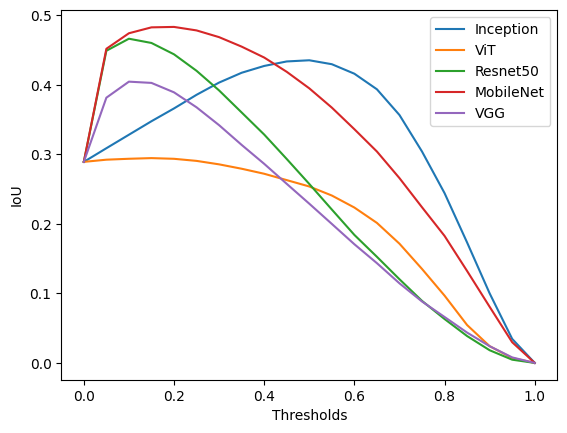

In [ ]:
x = thresholds
plt.plot(x, IoU_inception_avg,  label = "Inception")
plt.plot(x, IoU_vit_avg, label = "ViT")
plt.plot(x, IoU_resnet_avg, label = "Resnet50")
plt.plot(x, IoU_mobile_avg, label = "MobileNet")
plt.plot(x, IoU_vgg_avg, label = "VGG")
pyplot.xlabel('Thresholds')
pyplot.ylabel('IoU')
plt.legend()
plt.show()

# Red area outside annotated object

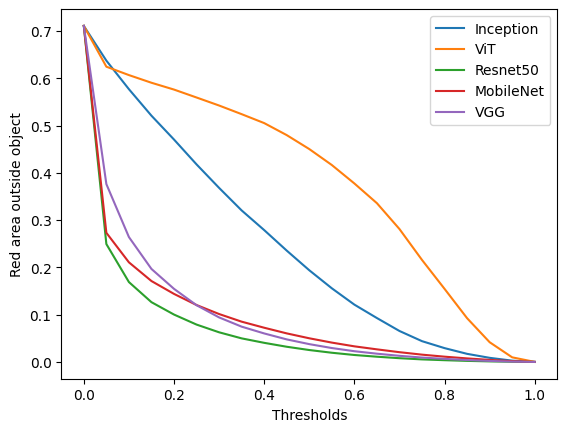

In [ ]:
x = thresholds
plt.plot(x, Prec_inception_avg,  label = "Inception")
plt.plot(x, Prec_vit_avg, label = "ViT")
plt.plot(x, Prec_resnet_avg, label = "Resnet50")
plt.plot(x, Prec_mobile_avg, label = "MobileNet")
plt.plot(x, Prec_vgg_avg, label = "VGG")
pyplot.xlabel('Thresholds')
pyplot.ylabel('Red area outside object')
plt.legend()
plt.show()

# F Score

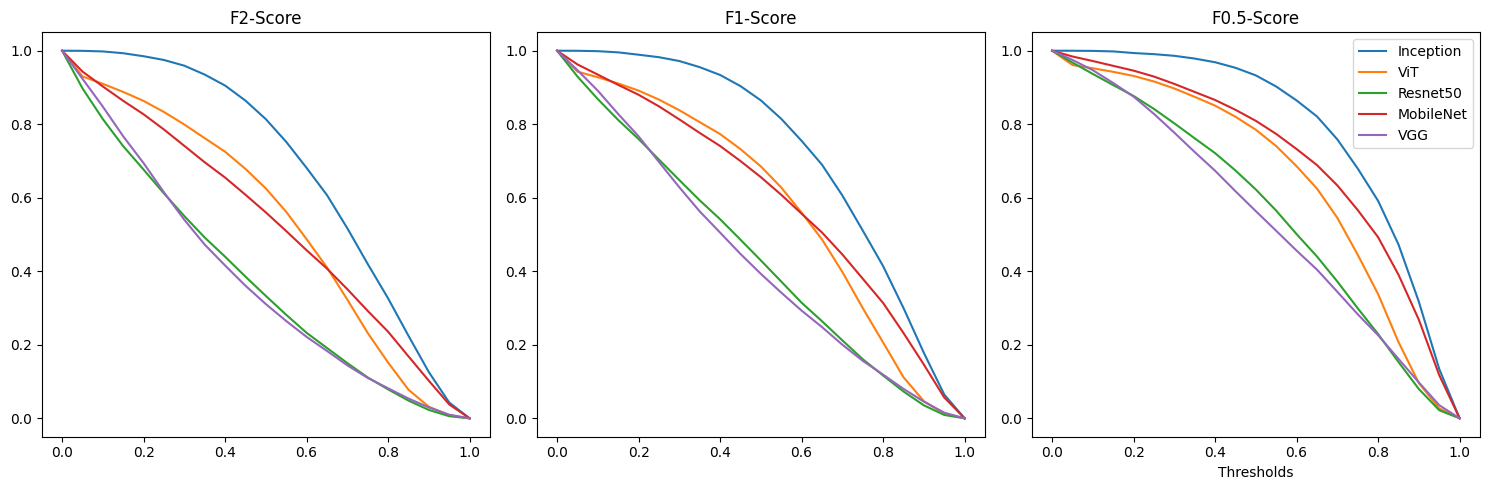

In [ ]:
x = thresholds
# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first graph on the first subplot
axes[0].plot(x, F2_inception_avg,  label = "Inception")
axes[0].plot(x, F2_vit_avg, label = "ViT")
axes[0].plot(x, F2_resnet_avg, label = "Resnet50")
axes[0].plot(x, F2_mobile_avg, label = "MobileNet")
axes[0].plot(x, F2_vgg_avg, label = "VGG")
axes[0].set_title('F2-Score')
pyplot.xlabel('Thresholds')

# Plot the second graph on the second subplot
axes[1].plot(x, F1_inception_avg,  label = "Inception")
axes[1].plot(x, F1_vit_avg, label = "ViT")
axes[1].plot(x, F1_resnet_avg, label = "Resnet50")
axes[1].plot(x, F1_mobile_avg, label = "MobileNet")
axes[1].plot(x, F1_vgg_avg, label = "VGG")
axes[1].set_title('F1-Score')
pyplot.xlabel('Thresholds')

# Plot the third graph on the third subplot
axes[2].plot(x, F0_inception_avg,  label = "Inception")
axes[2].plot(x, F0_vit_avg, label = "ViT")
axes[2].plot(x, F0_resnet_avg, label = "Resnet50")
axes[2].plot(x, F0_mobile_avg, label = "MobileNet")
axes[2].plot(x, F0_vgg_avg, label = "VGG")
pyplot.xlabel('Thresholds')
axes[2].set_title('F0.5-Score')
plt.legend()

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

#Tversky

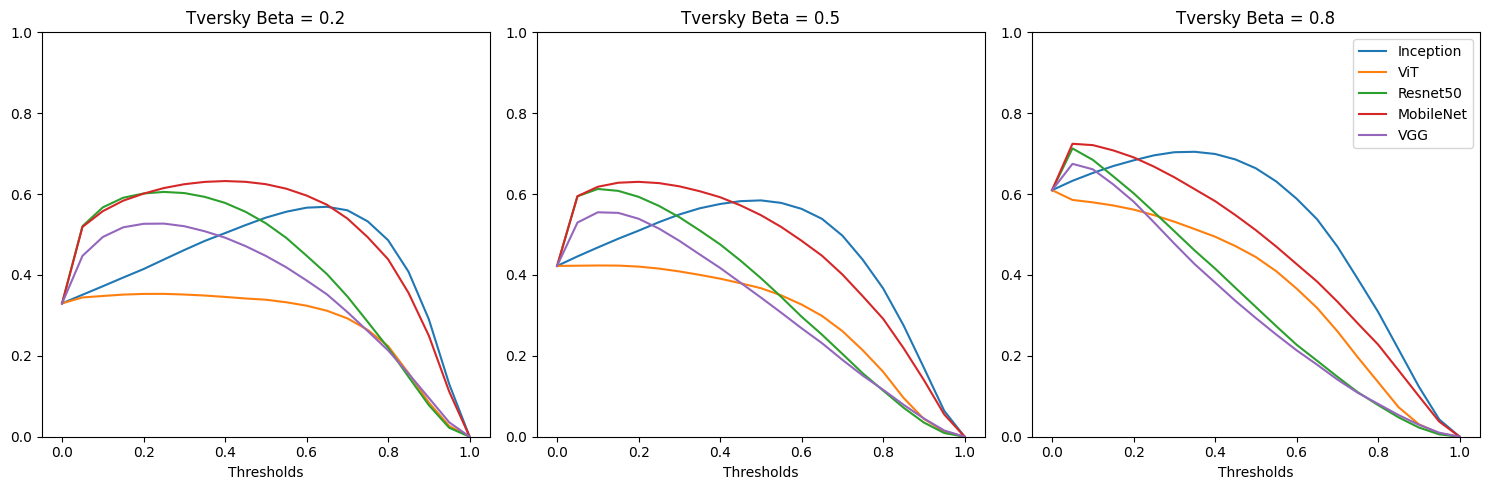

In [ ]:
x = thresholds
# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first graph on the first subplot
axes[0].plot(x, T1_inception_avg,  label = "Inception")
axes[0].plot(x, T1_vit_avg, label = "ViT")
axes[0].plot(x, T1_resnet_avg, label = "Resnet50")
axes[0].plot(x, T1_mobile_avg, label = "MobileNet")
axes[0].plot(x, T1_vgg_avg, label = "VGG")
axes[0].set_title('Tversky Beta = 0.2')
axes[0].set_ylim(0, 1)
axes[0].set_xlabel('Thresholds')

# Plot the second graph on the second subplot
axes[1].plot(x, T2_inception_avg,  label = "Inception")
axes[1].plot(x, T2_vit_avg, label = "ViT")
axes[1].plot(x, T2_resnet_avg, label = "Resnet50")
axes[1].plot(x, T2_mobile_avg, label = "MobileNet")
axes[1].plot(x, T2_vgg_avg, label = "VGG")
axes[1].set_title('Tversky Beta = 0.5')
axes[1].set_ylim(0, 1)
axes[1].set_xlabel('Thresholds')

# Plot the third graph on the third subplot
axes[2].plot(x, T3_inception_avg,  label = "Inception")
axes[2].plot(x, T3_vit_avg, label = "ViT")
axes[2].plot(x, T3_resnet_avg, label = "Resnet50")
axes[2].plot(x, T3_mobile_avg, label = "MobileNet")
axes[2].plot(x, T3_vgg_avg, label = "VGG")
axes[2].set_xlabel('Thresholds')
axes[2].set_title('Tversky Beta = 0.8')
axes[2].set_ylim(0, 1)

plt.legend()

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()